# Simulation & Rescheduling nach einem Tag (Regeneration)

In [2]:
import json
import pandas as pd
import numpy as np
import random

pd.set_option('display.max_rows', 30)

In [3]:
# Basics
import utils.basics.presenter as show
import utils.basics.converter as convert

import utils.checker as check
import utils.rolling_planning as rp
import utils.schedule_interarrival as sit

from ProductionDaySimulation import ProductionDaySimulation

In [4]:
import utils.schedule_solver__with_arrivals as ssv_a
import utils.reschedule.schedule_solver__arrival as rssv_a

In [5]:
# Datei laden
with open("data/jobshop_instances.json", "r", encoding="utf-8") as f:
    jobshop_instances = json.load(f)

instance =  jobshop_instances["instance ft10"]
df_instance = convert.jssp_dict_to_df(instance)

In [6]:
df_jssp, df_times = rp.init_jobs_with_arrivals(df_instance, 2,  u_b_mmax= 0.9)
df_jssp

,Job,Operation,Machine,Processing Time
0,Job_000,0,M0,29
1,Job_000,1,M1,78
2,Job_000,2,M2,9
3,Job_000,3,M3,36
4,Job_000,4,M4,49
...,...,...,...,...
375,Job_037,5,M9,76
376,Job_037,6,M5,47
377,Job_037,7,M3,52
378,Job_037,8,M4,90


In [7]:
df_times

,Job,Arrival
0,Job_000,0.00
1,Job_001,88.05
2,Job_002,152.78
3,Job_003,207.97
4,Job_004,246.61
...,...,...
33,Job_033,2630.89
34,Job_034,2637.28
35,Job_035,2638.72
36,Job_036,2764.04


## I) Complete Scheduling

In [9]:
df_plan, _ = ssv_a.solve_jssp_weighted_individual_flowtime(df_jssp, df_times, solver_time_limit = 300)
df_plan

,Job,Operation,Arrival,Machine,Start,Processing Time,Flow time,End
0,Job_000,0,0.00,M0,0.00,29,29.0,29.00
1,Job_000,1,0.00,M1,29.00,78,107.0,107.00
2,Job_000,2,0.00,M2,107.00,9,116.0,116.00
3,Job_000,3,0.00,M3,116.00,36,152.0,152.00
4,Job_000,4,0.00,M4,152.00,49,201.0,201.00
...,...,...,...,...,...,...,...,...
375,Job_037,5,2869.61,M9,4657.61,76,1864.0,4733.61
376,Job_037,6,2869.61,M5,4733.61,47,1911.0,4780.61
377,Job_037,7,2869.61,M3,5252.61,52,2435.0,5304.61
378,Job_037,8,2869.61,M4,5304.61,90,2525.0,5394.61


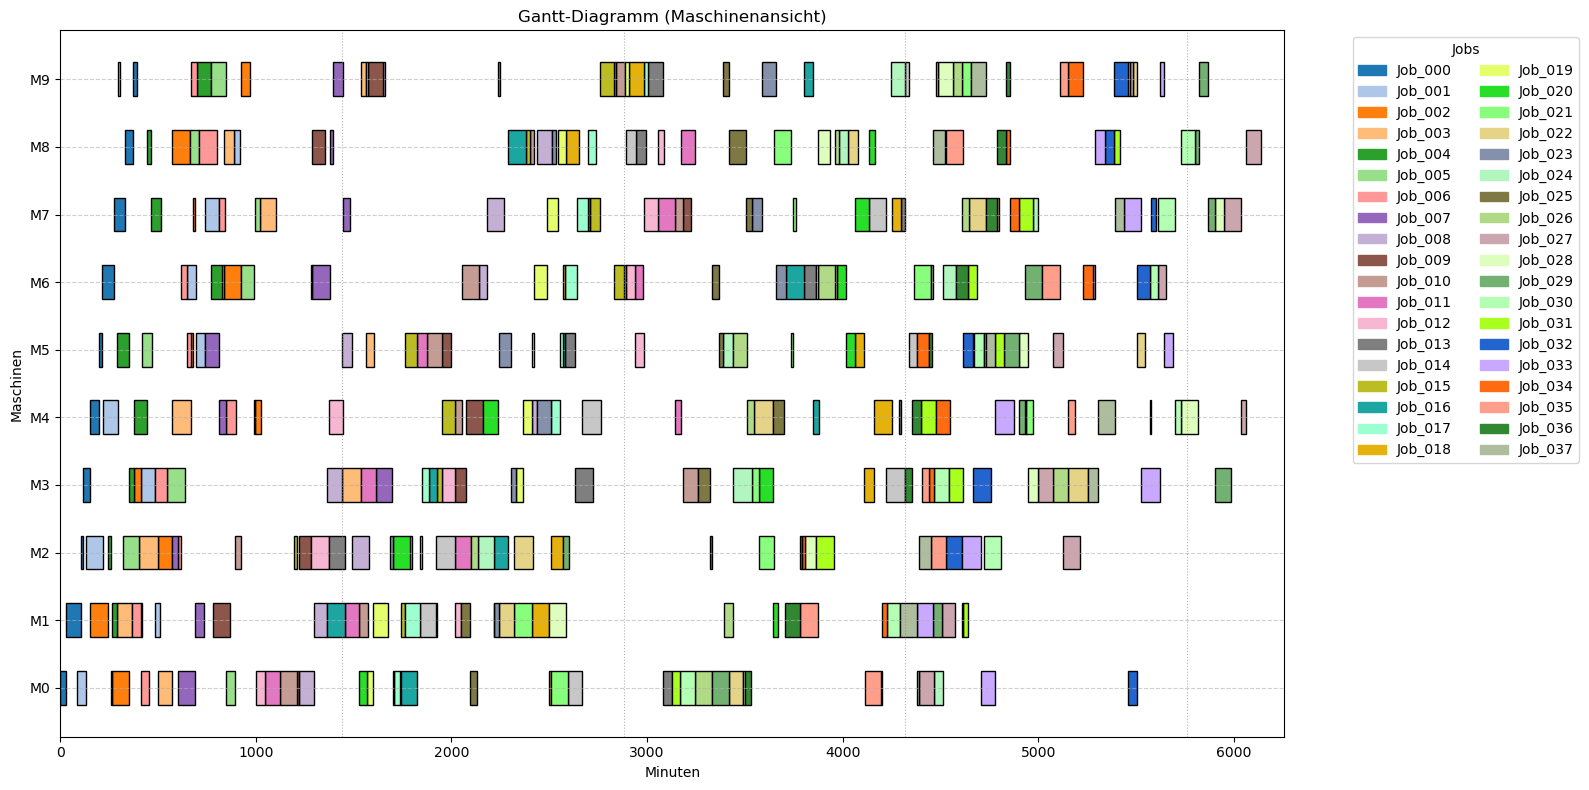

✅ Keine Maschinenkonflikte gefunden
✅ Für alle Jobs ist die Operationssequenz korrekt.
✅ Alle Operation starten erst nach Arrival des Job
✅ Zeitliche technologische Reihenfolge korrekt.

✅ Alle Constraints wurden erfüllt.



True

In [10]:
show.plot_gantt_machines(df_plan)
check.check_all_constraints(df_plan)

## II) First Day

### a) Simulation

In [13]:
day_start = 0
day_end = day_start + 1440

filt = (df_plan["Start"] >=  day_start) & (df_plan["Start"] < day_end)
df_schedule_day = df_plan[filt]
df_schedule_day

,Job,Operation,Arrival,Machine,Start,Processing Time,Flow time,End
0,Job_000,0,0.00,M0,0.00,29,29.00,29.00
1,Job_000,1,0.00,M1,29.00,78,107.00,107.00
2,Job_000,2,0.00,M2,107.00,9,116.00,116.00
3,Job_000,3,0.00,M3,116.00,36,152.00,152.00
4,Job_000,4,0.00,M4,152.00,49,201.00,201.00
...,...,...,...,...,...,...,...,...
121,Job_012,1,1003.56,M2,1282.56,90,369.00,1372.56
122,Job_012,2,1003.56,M4,1372.56,75,444.00,1447.56
130,Job_013,0,1185.73,M2,1372.56,84,270.83,1456.56
150,Job_015,0,1197.28,M2,1197.28,14,14.00,1211.28


In [91]:
simulation = ProductionDaySimulation(df_schedule_day, vc=0.4)
df_execution, df_undone = simulation.run(start_time = day_start, end_time=day_end)

[00:00:00] Job_000 started on M0
[01:04:39] Job_000 finished on M0 (after 64 minutes 40 seconds)
[01:04:39] Job_000 started on M1
[01:28:02] Job_001 started on M0
[02:08:13] Job_001 finished on M0 (after 40 minutes 11 seconds)
[02:11:03] Job_001 started on M2
[02:47:08] Job_000 finished on M1 (after 102 minutes 29 seconds)
[02:47:08] Job_002 started on M1
[02:56:39] Job_001 finished on M2 (after 45 minutes 36 seconds)
[02:56:39] Job_000 started on M2
[03:06:01] Job_000 finished on M2 (after 09 minutes 22 seconds)
[03:06:01] Job_000 started on M3
[03:18:49] Job_000 finished on M3 (after 12 minutes 48 seconds)
[03:18:49] Job_000 started on M4
[04:06:36] Job_004 started on M2
[04:12:54] Job_000 finished on M4 (after 54 minutes 05 seconds)
[04:12:54] Job_001 started on M4
[04:12:54] Job_000 started on M5
[04:13:48] Job_004 finished on M2 (after 07 minutes 11 seconds)
[04:20:36] Job_004 started on M0
[04:22:48] Job_000 finished on M5 (after 09 minutes 53 seconds)
[04:22:48] Job_000 started 

In [93]:
df_undone

,Job,Operation,Arrival,Machine,Planned Start,Processing Time
0,Job_012,2,1003.56,M4,1372.56,75
1,Job_013,0,1185.73,M2,1372.56,84


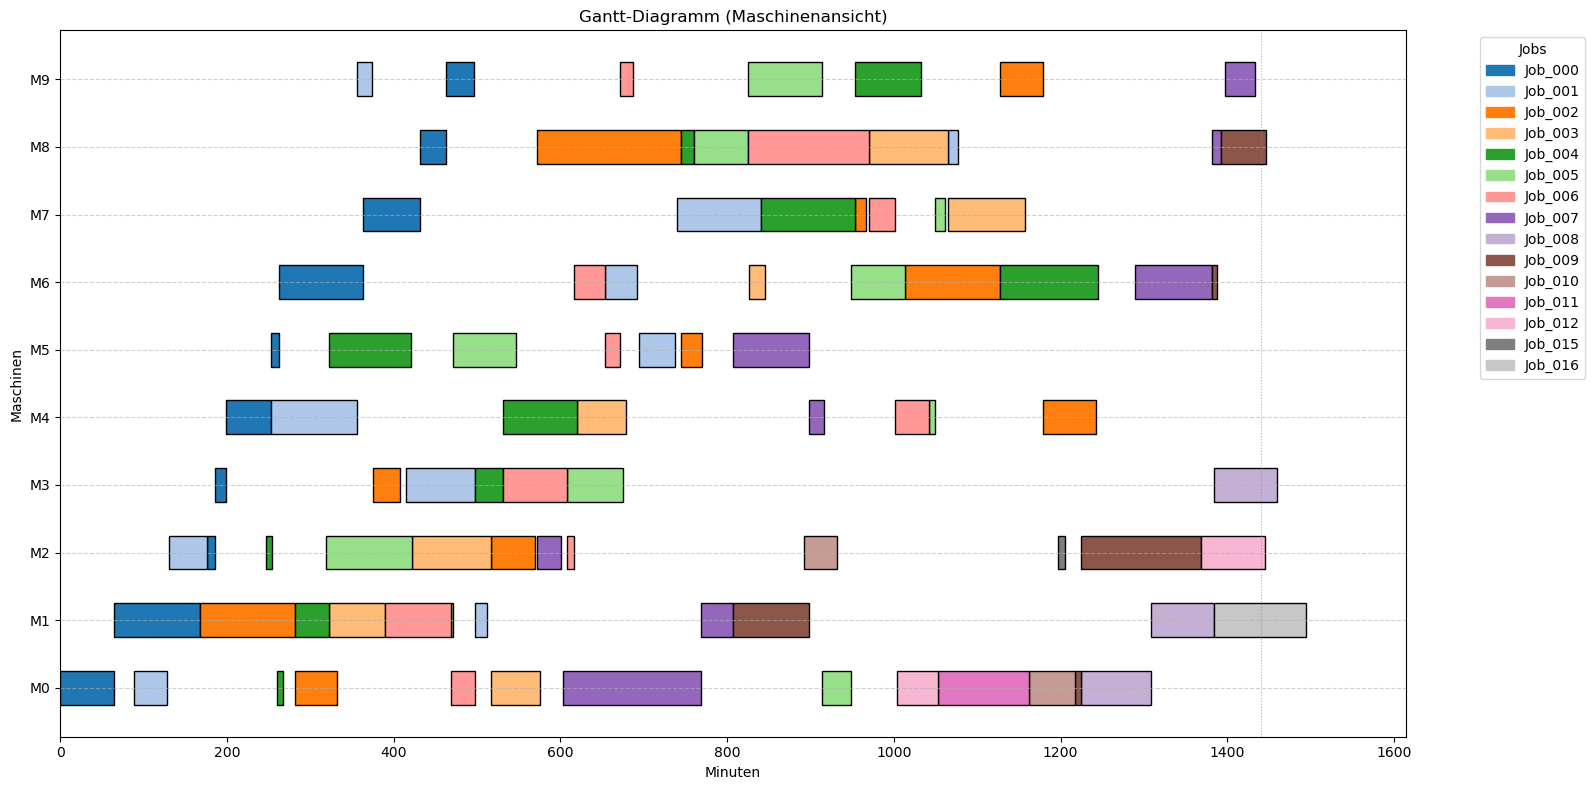

In [95]:
show.plot_gantt_machines(df_execution, duration_column = "Simulated Processing Time")

### b) Verbleibene Jobs (Rest)

In [98]:
df_rest = df_plan.merge(df_execution[["Job", "Machine"]], on=["Job", "Machine"], how="left", indicator=True)
df_rest = df_rest[df_rest["_merge"] == "left_only"].drop(columns=["_merge"])
df_rest = df_rest.sort_values(by=["Arrival", "Start"]).reset_index(drop=True)
df_rest

,Job,Operation,Arrival,Machine,Start,Processing Time,Flow time,End
0,Job_003,7,207.97,M3,1442.56,98,1332.59,1540.56
1,Job_003,8,207.97,M9,1540.56,22,1354.59,1562.56
2,Job_003,9,207.97,M5,1562.56,43,1397.59,1605.56
3,Job_007,8,515.63,M7,1444.56,36,964.93,1480.56
4,Job_007,9,515.63,M3,1616.56,79,1179.93,1695.56
...,...,...,...,...,...,...,...,...
285,Job_037,5,2869.61,M9,4657.61,76,1864.00,4733.61
286,Job_037,6,2869.61,M5,4733.61,47,1911.00,4780.61
287,Job_037,7,2869.61,M3,5252.61,52,2435.00,5304.61
288,Job_037,8,2869.61,M4,5304.61,90,2525.00,5394.61


In [100]:
allowed = df_rest["Job"].unique() 
df_time_rest = df_times[df_times["Job"].isin(allowed)].copy()
df_time_rest

,Job,Arrival
3,Job_003,207.97
7,Job_007,515.63
8,Job_008,748.04
9,Job_009,781.95
10,Job_010,891.94
...,...,...
33,Job_033,2630.89
34,Job_034,2637.28
35,Job_035,2638.72
36,Job_036,2764.04


## III) Rescheduling
> vereinfacht, ohne neu Aufträge (nur der Rest)

In [103]:
# Reduktion der bereits ausgeführten Operationen auf die relevanten für die nächsten Tage
df_execution_important = df_execution[df_execution["End"] >= 1440]
df_execution_important

,Job,Operation,Arrival,Machine,Start,Simulated Processing Time,Flow time,End
77,Job_008,2,748.04,M3,1384.49,75.03,711.48,1459.52
82,Job_009,4,781.95,M8,1391.91,53.77,663.73,1445.68
87,Job_012,1,1003.56,M2,1368.34,76.56,441.34,1444.90
89,Job_016,0,1198.72,M1,1384.49,109.75,295.52,1494.24


In [105]:
df_reschedule = rssv_a.solve_jssp_individual_flowtime_with_fixed_ops(
    df_rest, df_time_rest, df_execution_important, 
    solver_time_limit = 300, arrival_column = "Arrival",
    reschedule_start = 1440
)

✅ Fertig!


In [106]:
df_reschedule

,Job,Operation,Arrival,Machine,Start,Processing Time,Flow time,End
0,Job_003,7,207.97,M3,2059.0,98.0,1949.03,2157.0
1,Job_003,8,207.97,M9,3221.0,22.0,3035.03,3243.0
2,Job_003,9,207.97,M5,3243.0,43.0,3078.03,3286.0
3,Job_007,8,515.63,M7,1440.0,36.0,960.37,1476.0
4,Job_007,9,515.63,M3,1476.0,79.0,1039.37,1555.0
...,...,...,...,...,...,...,...,...
285,Job_037,5,2869.61,M9,7132.0,76.0,4338.39,7208.0
286,Job_037,6,2869.61,M5,7208.0,47.0,4385.39,7255.0
287,Job_037,7,2869.61,M3,7255.0,52.0,4437.39,7307.0
288,Job_037,8,2869.61,M4,7307.0,90.0,4527.39,7397.0


### Export

In [108]:
df_plan.to_csv("data/03a_origininal_schedule.csv", index = False)
df_execution.to_csv("data/03b_schedule_simulation.csv", index = False)
df_reschedule.to_csv("data/03c_new_schedule.csv", index = False)

In [109]:
df_execution = df_execution.rename(columns={"Simulated Processing Time": "Processing Time"})

df_schedule_mix = pd.concat([df_execution, df_reschedule], ignore_index=True)
df_schedule_mix = df_schedule_mix.sort_values(by="Start").reset_index(drop=True)
df_schedule_mix

,Job,Operation,Arrival,Machine,Start,Processing Time,Flow time,End
0,Job_000,0,0.00,M0,0.00,64.66,64.66,64.66
1,Job_000,1,0.00,M1,64.66,102.48,167.14,167.14
2,Job_001,0,88.05,M0,88.05,40.18,40.18,128.23
3,Job_001,1,88.05,M2,131.05,45.60,88.60,176.65
4,Job_002,0,152.78,M1,167.14,114.63,128.99,281.77
...,...,...,...,...,...,...,...,...
375,Job_027,9,2188.04,M8,8787.00,74.00,6672.96,8861.00
376,Job_032,7,2625.73,M6,8802.00,65.00,6241.27,8867.00
377,Job_008,9,748.04,M8,8861.00,74.00,8186.96,8935.00
378,Job_032,8,2625.73,M4,8867.00,6.00,6247.27,8873.00


In [110]:
df_schedule_mix.to_csv("data/03d_new_schedule_complete.csv", index = False)